# Classification de phrases

Le texte est toujours délicat à traiter. La langue est importante et plus le vocabulaire est étendu, plus il faut de données. Le problème qui suit est classique, on cherche à catégoriser des phrases en sentiment positif ou négatif. Ce pourrait être aussi classer des spams. Le problème le plus simple : une phrase, un label.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [3]:
%matplotlib inline

## Les données

Elles proviennent de [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences).

In [4]:
from papierstat.datasets import load_sentiment_dataset
df = load_sentiment_dataset()
df.head()

,sentance,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon_cells_labelled
1,"Good case, Excellent value.",1,amazon_cells_labelled
2,Great for the jawbone.,1,amazon_cells_labelled
3,Tied to charger for conversations lasting more...,0,amazon_cells_labelled
4,The mic is great.,1,amazon_cells_labelled


In [5]:
df.groupby(['source', 'sentiment']).count()

sentance
source                sentiment          
amazon_cells_labelled 0               500
                      1               500
imdb_labelled         0               500
                      1               500
yelp_labelled         0               500
                      1               500

On découpe en train and test.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[["sentance"]], df['sentiment'])

## L'approche classique

[TF-IDF](https://fr.wikipedia.org/wiki/TF-IDF) est une approche très répandue lorsqu'il s'agit de convertir des phrases en features.

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(CountVectorizer(), TfidfTransformer())
pipe.fit(X_train['sentance'])
feat_train = pipe.transform(X_train['sentance'])
feat_train.shape

(2250, 4413)

In [8]:
feat_train.min(), feat_train.max()

(0.0, 1.0)

In [9]:
feat_test = pipe.transform(X_test['sentance'])
feat_test.shape

(750, 4413)

In [10]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50)
clf.fit(feat_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
clf.score(feat_test, y_test)

0.7946666666666666

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
score = clf.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])

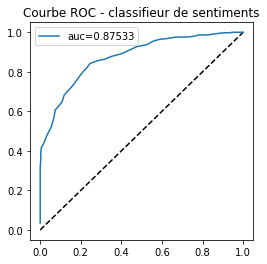

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

## Les n-grammes

L'approche présentée ci-dessus ne tient pas compte de l'ordre des mots. Chaque phrase est convertie en un sac de mots (ou [bag of words](https://fr.wikipedia.org/wiki/Sac_de_mots)). Il est néanmoins possible de tenir compte de séquence plus ou moins longue.

In [14]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
generated_ngrams = ngrams(word_tokenize(X_train.iloc[0,0]), 3, pad_left=True, pad_right=True)
list(generated_ngrams)[:7]

[(None, None, 'My'),
 (None, 'My', 'side'),
 ('My', 'side', 'Greek'),
 ('side', 'Greek', 'salad'),
 ('Greek', 'salad', 'with'),
 ('salad', 'with', 'the'),
 ('with', 'the', 'Greek')]

[scikit-learn](http://scikit-learn.org/stable/modules/feature_extraction.html#limitations-of-the-bag-of-words-representation) permet d'essayer cette idée simplement.

In [15]:
pipe2 = make_pipeline(CountVectorizer(ngram_range=(1, 2)),
                      TfidfTransformer())
pipe2.fit(X_train['sentance'])
feat_train2 = pipe2.transform(X_train['sentance'])
feat_train2.shape

(2250, 20212)

Il y a plus de colonnes, on vérifie malgré tout que les features ressemblent à des couples de mots.

In [16]:
cl = pipe2.steps[0]
cl[1].get_feature_names()[:10]

['00',
 '10',
 '10 10',
 '10 and',
 '10 for',
 '10 grade',
 '10 minutes',
 '10 of',
 '10 on',
 '10 out']

C'est le cas.

In [17]:
feat_test2 = pipe2.transform(X_test['sentance'])

In [18]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(n_estimators=50)
clf2.fit(feat_train2, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
clf2.score(feat_test2, y_test)

0.776

Cela n'améliore pas de façon significative. Il faudrait faire une cross-validation pour s'en assurer.

## word2vec

In [20]:
from gensim.utils import tokenize
sentance = [list(tokenize(s, deacc=True, lower=True)) for s in X_train['sentance']]
sentance[0]

c:\python365_x64\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


['my',
 'side',
 'greek',
 'salad',
 'with',
 'the',
 'greek',
 'dressing',
 'was',
 'so',
 'tasty',
 'and',
 'the',
 'pita',
 'and',
 'hummus',
 'was',
 'very',
 'refreshing']

In [21]:
from gensim.models import word2vec
model = word2vec.Word2Vec(sentance, size=100, window=20, min_count=1, workers=1, iter=20)
model.corpus_count

2250

In [22]:
vocab = model.wv.vocab
list(vocab)[:5]

['my', 'side', 'greek', 'salad', 'with']

In [23]:
model.save('trained_word2vec.bin')

Le vecteur associé au mot ``after``.

In [24]:
model.wv['after']

array([ 2.07838520e-01, -1.25373363e-01,  5.04939556e-01,  3.14421892e-01,
        1.42095476e-01,  2.31417865e-02, -4.40994650e-01,  5.29118367e-02,
        6.09005451e-01, -3.06808352e-01,  5.24850845e-01, -4.24110070e-02,
        5.05102575e-01, -5.13417602e-01,  7.32481062e-01,  1.77681431e-01,
        4.90849555e-01, -1.32047206e-01, -4.82204914e-01,  3.89789581e-01,
        1.10815719e-01, -3.03340882e-01,  1.21135879e+00,  1.72070861e-01,
        5.68732560e-01,  5.85373342e-01, -3.83881778e-01,  1.33783734e+00,
        7.35913694e-01, -8.14073920e-01,  1.46397507e+00,  2.75095224e-01,
        2.47424364e-01,  2.57372379e-01, -2.82851905e-01, -8.75639737e-01,
       -2.40563095e-01,  1.44877744e+00,  1.27904892e-01, -3.90580356e-01,
        5.55871904e-01,  1.02727056e-01, -2.76568085e-01,  2.98357517e-01,
        1.60174124e-04, -3.47114205e-02,  7.13078856e-01, -5.62659860e-01,
        6.97398365e-01,  2.14962229e-01,  4.70708832e-02,  1.63327411e-01,
       -4.27388608e-01, -

Lorsque le mot est inconnu :

In [25]:
try:
    model.wv['rrrrrrrr']
except KeyError as e:
    print(e)

"word 'rrrrrrrr' not in vocabulary"


Pour chaque phrase, on fait la somme des vecteurs associés aux mots qui la composent ou pas si le mot n'est pas dans le vocabulaire. Il y a probablement des fonctions déjà prêtes à l'emploi mais la documentation de [gensim](https://radimrehurek.com/gensim/index.html) n'était pas assez explicite.

In [26]:
import numpy

def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return numpy.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(X, model):
    feats = numpy.vstack([sum_vectors(p, model) for p in X])
    return feats

wv_train_feat = word2vec_features(X_train["sentance"], model)
wv_train_feat.shape

(2250, 100)

In [27]:
clfwv = RandomForestClassifier(n_estimators=50)
clfwv.fit(wv_train_feat, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
wv_test_feat = word2vec_features(X_test["sentance"], model)

In [29]:
clfwv.score(wv_test_feat, y_test)

0.5226666666666666

La performance est nettement moindre, il faudra sans doute jouer avec les hyperparamètres de l'apprentissage ou réutiliser un model appris sur un corpus similaire aux données initiales mais nettement plus grand. On peut constater que la fonction de similarités ne retourne pas des résultats très intéressant.

In [30]:
model.wv.similarity("after", "before")

0.9995070966531814

In [31]:
model.wv.similarity("after", "greek")

0.9954822092435411

In [32]:
model.wv.similarity("dressing", "greek")

0.9991161721318413

## word2vec pré-entraînés

On peut télécharger des modèles pré-entraîner sur des données plus volumineuses :
 [Pre-Trained Word2Vec Models](https://github.com/jhlau/doc2vec) ou encore [Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors). Ceux-ci snt plutôt gros (> 600 Mo). Le module *spacy* propose une version plus légère et mieux documentée [Word Vectors and Semantic Similarity](https://spacy.io/usage/vectors-similarity) avec les données [en_core_web_md](https://github.com/explosion/spacy-models/releases).

In [33]:
import spacy
from spacy.cli import download
# download("en_core_web_md")  # ça ne marche pas toujours

In [34]:
import os
unzip_dest = 'en_core_web_md-2.0.0.tar/dist/en_core_web_md-2.0.0/en_core_web_md/en_core_web_md-2.0.0'
if os.path.exists(unzip_dest):
    nlp = spacy.load(unzip_dest)
    continue_wv = True
else:
    continue_wv = False
    print('Pas de données on passe la suite.')

In [35]:
if continue_wv:
    tokens = nlp('after before greek dressing')
    for token1 in tokens:
        for token2 in tokens:
            print(token1.text, token2.text, token1.similarity(token2))
    print(tokens[0].vector)

after after 1.0
after before 0.87566733
after greek 0.08783853
after dressing 0.24195954
before after 0.87566733
before before 1.0
before greek 0.0960651
before dressing 0.28992757
greek after 0.08783853
greek before 0.0960651
greek greek 1.0
greek dressing 0.28894117
dressing after 0.24195954
dressing before 0.28992757
dressing greek 0.28894117
dressing dressing 1.0
[ 2.0690e-01  4.4321e-01 -1.2522e-01 -1.7724e-02 -6.4277e-02 -4.4308e-01
  1.4019e-02 -1.0119e-01  2.2699e-01  3.1689e+00 -4.9675e-02  1.3649e-01
 -1.2854e-01 -8.9205e-02 -1.8400e-01 -2.6894e-01 -1.0977e-01  5.8782e-01
  5.5505e-02 -1.0928e-01 -1.0306e-01 -2.2621e-01 -4.0278e-01 -7.0180e-03
 -8.1239e-02  9.1405e-02 -2.0647e-01 -8.8109e-02  1.8322e-02  1.3885e-01
 -1.4916e-01 -3.4279e-01  3.4073e-01 -2.0525e-02  1.2772e-01  1.9344e-01
 -4.2443e-02 -8.1455e-02  2.4402e-01 -1.0637e-01  2.6051e-01 -4.2693e-02
  2.7589e-01  3.6389e-02 -4.5583e-01  3.3536e-01 -6.3138e-01  1.0534e-02
 -9.8558e-02 -2.6224e-01 -3.4218e-02  2.2529e-

In [36]:
import numpy

def spacy_sum_vectors(phrase, nlp):
    dec = nlp(phrase)
    return sum(w.vector for w in dec)

def spacy_word2vec_features(X, nlp):
    feats = numpy.vstack([spacy_sum_vectors(p, nlp) for p in X])
    return feats

if continue_wv:
    wv_train_feat2 = spacy_word2vec_features(X_train["sentance"], nlp)
    print(wv_train_feat2.shape)

(2250, 300)


In [37]:
if continue_wv:
    clfwv2 = RandomForestClassifier(n_estimators=50)
    clfwv2.fit(wv_train_feat2, y_train)

In [38]:
if continue_wv:
    wv_test_feat2 = spacy_word2vec_features(X_test["sentance"], nlp)

In [39]:
if continue_wv:
    print(clfwv2.score(wv_test_feat2, y_test))

0.7866666666666666


C'est un peu mieux mais un peu plus coûteux en temps de calcul. La suite serait d'utiliser les n-grammes.